# Sea surface temperature: realtime maps
----

J. Potemra<br>
February 2024

----
This notebook will access satellite-derived sea surface temperature (SST) and SST anomalies and produce maps of the near-real-time values.

The data come from the NOAA Coral Reef Watch (CRW) version 3.1 operational global satellite coral bleaching heat stress monitoring products at 5-km resolution produced daily in near real-time, including sea surface temperature (SST), SST anomaly, HotSpot, Degree Heating Week (DHW), and Bleaching Alert Area (BAA). These data are based on CoralTemp Version 1.0, a daily global 5-km sea surface temperature dataset combined from: (1.) NOAA/NESDIS operational near-real-time daily global 5-km geostationary-polar-orbiting (geo-polar) blended night-only SST analysis, (2.) NOAA/NESDIS 2002-2016 reprocessed daily global 5-km geo-polar blended night-only SST analysis, and (3.) United Kingdom Met Office 1985-2002 daily global 5-km night-only SST reanalysis of Operational SST and Sea Ice Analysis (OSTIA). The SST anomaly is the difference of SST compared to daily SST climatology. The coral bleaching HotSpot is a special type of sea surface temperature (SST) anomaly and shows the difference of SST compared to a coral bleaching SST threshold climatology. DHW is the accumulation of Coral Bleaching HotSpots over a period of 12 consecutive weeks. The DHW value at any particular location at any particular time is the summation of the product of HotSpot values which are at least 1 deg C above the bleaching threshold SST and their durations in weeks over the most recent 12-week period. One DHW is equivalent to 1 week of SST at 1 deg C above the threshold or 0.5 week of SST at 2 deg C above the threshold, etc. The units for DHW are deg C-weeks, combining the intensity and duration of heat stress into one single number. Based on research at Coral Reef Watch, when the heat stress reaches 4 deg C-weeks, you can expect to see significant coral bleaching, especially in more sensitive species. When heat stress is 8 deg C-weeks or higher, you would likely see widespread bleaching and mortality from the heat stress. For access to the full time series, use PacIOO

The data are accessed from the PacIOOS OPeNDAP server at https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/dhw_5km

## Import needed packages

In [1]:
# data I/O and processing
import xarray as xr
import pandas as pd
import numpy as np

# data plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import geopandas as gpd

## Define lat/lon/time ranges for display

In [2]:
# define lat/lon range for Palau
min_lat = 0.0
max_lat = 13.0
min_lon = 128.0
max_lon = 138.0

## Get most recent time

In [3]:
url = 'https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/dhw_5km'
ds = xr.open_dataset(url)
# note here that the CRW data set has latitude from +90 to -90, so need
# to "slice" in the reverse order, i.e., from max_lat to min_lat
ds = ds.sel( longitude = slice(min_lon,max_lon), latitude = slice(max_lat,min_lat) )

# get last time
sst = ds['CRW_SST'][-1,:,:]
ssta = ds['CRW_SSTANOMALY'][-1,:,:]

# also read the EEZ as a shape file
shape_gpd = gpd.read_file('./data/pw_eez_line_april2022.shp')

## Make a plot
Here we define a couple functions to add fancy axes and maps/coastlines to our figures.  First we set some "global attributes" like the geographic extent of the maps, map projection, _etc._

In [4]:
# Plot parameters
# geographic range; Note here use the maximum extent of the data, but
# we could also do a smaller (clipped) or large (white space) region
lon_range = [min_lon, max_lon]
lat_range = [min_lat, max_lat]

# color range for shading (in degrees C)
sst_color_min, sst_color_max = 28, 30
ssta_color_min, ssta_color_max = -1.5, 1.5

# projection
crs = ccrs.PlateCarree()

In [5]:
# add alternating black and white bars to map axes
def add_zebra_frame(ax, lw=2, segment_length=0.5, crs=ccrs.PlateCarree()):
    # Get the current extent of the map
    left, right, bot, top = ax.get_extent(crs=crs)

    # Calculate the nearest 0 or 0.5 degree mark within the current extent
    left_start = left - left % segment_length
    bot_start = bot - bot % segment_length

    # Adjust the start if it does not align with the desired segment start
    if left % segment_length >= segment_length / 2:
        left_start += segment_length
    if bot % segment_length >= segment_length / 2:
        bot_start += segment_length

    # Extend the frame slightly beyond the map extent to ensure full coverage
    right_end = right + (segment_length - right % segment_length)
    top_end = top + (segment_length - top % segment_length)

    # Calculate the number of segments needed for each side
    num_segments_x = int(np.ceil((right_end - left_start) / segment_length))
    num_segments_y = int(np.ceil((top_end - bot_start) / segment_length))
    
    # Draw horizontal stripes at the top and bottom
    for i in range(num_segments_x):
        #color = 'black' if (left_start + i * segment_length) % (2 * segment_length) == 0 else 'white'
        color = 'black' if (i * segment_length) % (2 * segment_length) == 0 else 'white'
        start_x = left_start + i * segment_length
        end_x = start_x + segment_length
        ax.hlines([bot, top], start_x, end_x, colors=color, linewidth=lw, transform=crs)

    # Draw vertical stripes on the left and right
    for j in range(num_segments_y):
        #color = 'black' if (bot_start + j * segment_length) % (2 * segment_length) == 0 else 'white'
        color = 'black' if (j * segment_length) % (2 * segment_length) == 0 else 'white'
        start_y = bot_start + j * segment_length
        end_y = start_y + segment_length
        ax.vlines([left, right], start_y, end_y, colors=color, linewidth=lw, transform=crs)

# plot the land and coastlines
def plot_map(vmin, vmax, xlims, ylims):
    """
    Plot a map of the magnitude of sea level change.

    Parameters:
    vmin (float): Minimum value for the color scale.
    vmax (float): Maximum value for the color scale.
    xlims (tuple): Tuple of min and max values for the x-axis limits.
    ylims (tuple): Tuple of min and max values for the y-axis limits.

    Returns:
    fig (matplotlib.figure.Figure): The matplotlib figure object.
    ax (matplotlib.axes._subplots.AxesSubplot): The matplotlib axes object.
    crs (cartopy.crs.Projection): The cartopy projection object.
    cmap (matplotlib.colors.Colormap): The colormap used for the plot.
    """
    crs = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': crs})
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    palette = sns.color_palette("mako", as_cmap=True)
    cmap = palette

    ax.coastlines()
    ax.add_feature(cfeature.LAND, color='lightgrey')

    return fig, ax, crs, cmap

def plot_zebra_frame(ax, lw=5, segment_length=2, crs=ccrs.PlateCarree()):
    """
    Plot a zebra frame on the given axes.

    Parameters:
    - ax: The axes object on which to plot the zebra frame.
    - lw: The line width of the zebra frame. Default is 5.
    - segment_length: The length of each segment in the zebra frame. Default is 2.
    - crs: The coordinate reference system of the axes. Default is ccrs.PlateCarree().
    """
    # Call the function to add the zebra frame
    add_zebra_frame(ax=ax, lw=lw, segment_length=segment_length, crs=crs)
    # add map grid
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5,xlocs=ax.get_xticks(),ylocs=ax.get_yticks())
    #remove labels from top and right axes
    gl.top_labels = False
    gl.right_labels = False

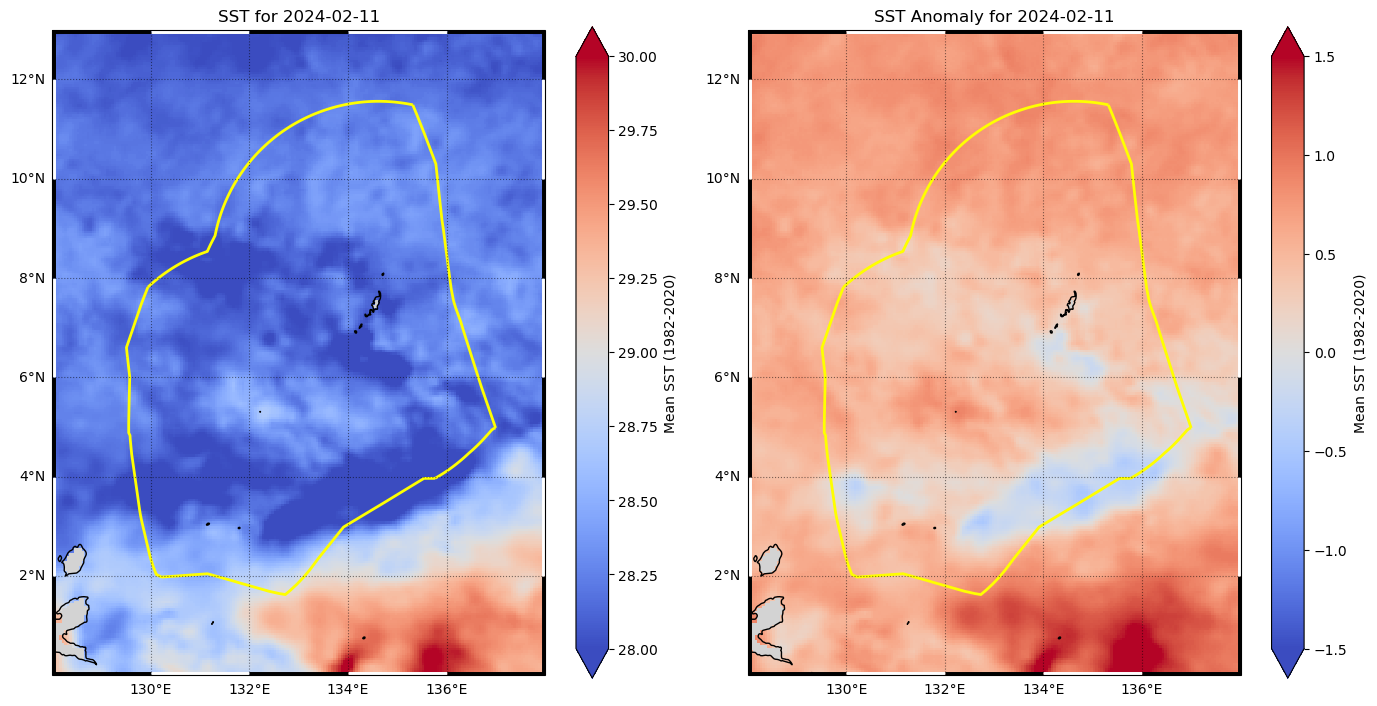

In [6]:
# make a two-panel plot

cmap = sns.color_palette("coolwarm", as_cmap=True)
plot_title = ['SST', 'SST Anomaly']
date = np.array2string(sst['time'].values)[1:11]

fig, ax = plt.subplots( nrows = 1, ncols = 2, figsize=(14,7), subplot_kw={'projection': crs} )

sst.plot( ax=ax[0], transform=crs, robust=True,
                           vmin=sst_color_min, vmax=sst_color_max, 
                           cmap=cmap, add_colorbar=True, extend='both',
                           cbar_kwargs={'label': 'Mean SST (1982-2020)'},)

ssta.plot( ax=ax[1], transform=crs, robust=True,
                           vmin=ssta_color_min, vmax=ssta_color_max, 
                           cmap=cmap, add_colorbar=True, extend='both',
                           cbar_kwargs={'label': 'Mean SST (1982-2020)'},)
for i in range(2):
    ax[i].set_xlim(lon_range)
    ax[i].set_ylim(lat_range)
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    ax[i].coastlines()
    ax[i].add_feature(cfeature.LAND, color='lightgrey')      
    ax[i].set_title(plot_title[i] + ' for ' + date)

    # Call the function to add the zebra frame
    plot_zebra_frame(ax[i], lw=5, segment_length=2.0, crs=crs)

    # add the EEZ
    shape_gpd.plot(ax=ax[i],color='yellow',transform=crs, linewidth=2);

plt.tight_layout()
plt.savefig('./images/temp_current_map.png')